In [1]:
## Sources 
# 1. https://github.com/Thomas-George-T/Appliance-Energy-Prediction/blob/main/Appliances%20Energy%20predicition%20Notebook.ipynb
# 2. https://codezup.com/practical-python-for-time-series-analysis/#:~:text=This%20tutorial%20guides%20you%20through%20practical%20Python%20techniques,Types%3A%20Univariate%20%28single%20variable%29%20and%20multivariate%20%28multiple%20variables%29.


## Step 1: Import Library

In [1]:
from ucimlrepo import list_available_datasets
from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose


## Step 2: Load Datasets

In [2]:
dataset_name = "Appliances Energy Prediction"
dataset = fetch_ucirepo(name=dataset_name)

In [3]:
# Convert features and target to DataFrame
df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

In [4]:
df.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,2016-01-1117:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,2016-01-1117:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,2016-01-1117:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,2016-01-1117:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
4,2016-01-1117:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


## Step 3: Preprocess Data 

In [5]:
# Check for missing values 
print(df.isnull().sum())

date           0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
Appliances     0
dtype: int64


In [6]:
# Step 1: Fix dashes
df['date'] = df['date'].str.replace('–', '-', regex=False)

# Step 2: Insert a 'T' between date and time
df['date'] = df['date'].str.replace(r'(\d{4}-\d{2}-\d{2})(\d{2}:\d{2}:\d{2})', r'\1T\2', regex=True)

# Step 3: Convert to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')


In [7]:
df.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
4,2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [8]:
# Set datetime index
df.set_index('date', inplace=True)


In [9]:
# Resample to hourly mean values
df_hourly = df.resample('H').mean()

/tmp/ipykernel_32981/356360559.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


In [26]:
df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [27]:
df.shape

(19735, 28)

In [11]:
df_hourly.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,17.166667,...,45.446667,6.308333,733.750000,92.000000,6.166667,53.416667,5.050000,26.823044,26.823044,55.000000
2016-01-11 18:00:00,51.666667,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,46.066667,17.111111,...,45.290000,5.941667,734.266667,91.583333,5.416667,40.000000,4.658333,22.324206,22.324206,176.666667
2016-01-11 19:00:00,25.000000,20.495556,52.805556,19.925556,46.061667,20.052222,47.227361,18.969444,47.815556,17.136111,...,45.311389,6.000000,734.791667,89.750000,6.000000,40.000000,4.391667,33.734932,33.734932,173.333333
2016-01-11 20:00:00,35.000000,20.961111,48.453333,20.251111,45.632639,20.213889,47.268889,19.190833,49.227917,17.615556,...,45.118889,6.000000,735.283333,87.583333,6.000000,40.000000,4.016667,25.679642,25.679642,125.000000
2016-01-11 21:00:00,23.333333,21.311667,45.768333,20.587778,44.961111,20.373333,46.164444,19.425556,47.918889,18.427222,...,44.807778,5.833333,735.566667,87.416667,6.000000,40.000000,3.816667,18.826274,18.826274,103.333333


In [12]:
df_hourly.shape

(3290, 28)

In [13]:
# Decompose the 'Appliances' time series
decomposition = seasonal_decompose(df_hourly['Appliances'], model='additive', period=24)  # 24 for daily seasonality

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

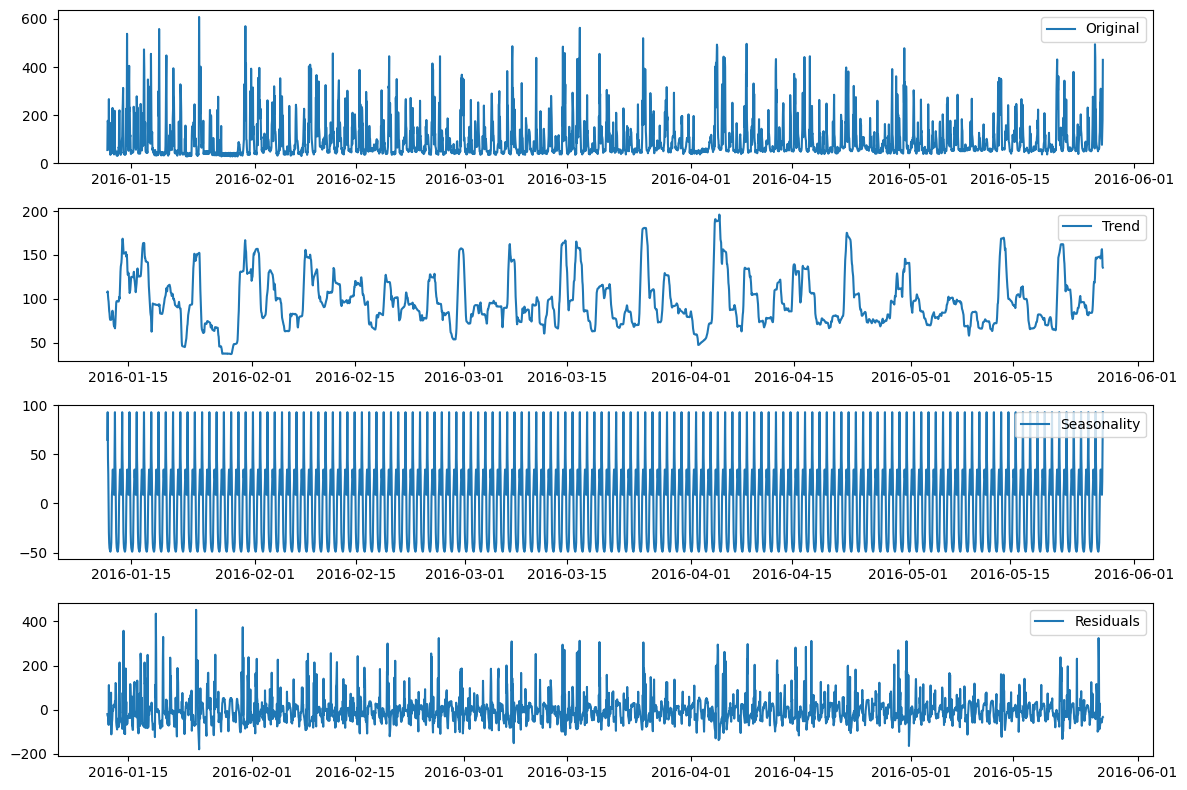

In [14]:
# Plot
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_hourly['Appliances'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


## Step 5: Check Stationarity 

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_hourly['Appliances'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF Statistic: -8.948888280256888
p-value: 8.833753129594426e-15
Critical Values:
1% -3.432357502010421
5% -2.862426994644342
10% -2.567242166152283


## Step 6: Split Data 

In [16]:
train_data, test_data = train_test_split(df_hourly, test_size=0.2, shuffle=False)

In [17]:
len(train_data), len(test_data)

(2632, 658)

## Step 7: Training Model

In [18]:
# Example parameters (replace with your values)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 24

In [19]:
# Fit the SARIMAX model
model = SARIMAX(train_data['Appliances'],  # Target variable
                order=(p, d, q),         # ARIMA parameters
                seasonal_order=(P, D, Q, s),  # Seasonal parameters
                enforce_stationarity=False,  # Allow non-stationary data
                enforce_invertibility=False) # Allow non-invertible MA terms

results = model.fit()  # Fit the model

In [20]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Appliances   No. Observations:                 2632
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -14442.018
Date:                            Wed, 23 Apr 2025   AIC                          28894.035
Time:                                    05:01:03   BIC                          28923.315
Sample:                                01-11-2016   HQIC                         28904.648
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4820      0.012     41.305      0.000       0.459       0.505
ma.L1         -1.0000      0.715   

## Step 8 : Make Predictions

In [ ]:
# Define the start and end indices for the test set
start = len(train_data)  # Start index (end of training set)
end = len(df_hourly) - 1  # End index (end of the dataset)

# Generate predictions for the test set
test_predictions = results.predict(start=start, end=end)

# Print predictions
print(test_predictions)

2016-04-30 09:00:00    219.949789
2016-04-30 10:00:00    177.490216
2016-04-30 11:00:00    156.259108
2016-04-30 12:00:00    122.166175
2016-04-30 13:00:00    120.317134
                          ...    
2016-05-27 14:00:00    102.243370
2016-05-27 15:00:00    102.498806
2016-05-27 16:00:00    125.885135
2016-05-27 17:00:00    180.742315
2016-05-27 18:00:00    193.175532
Freq: h, Name: predicted_mean, Length: 658, dtype: float64

## Step 9: Evaluation 

In [23]:
# Compare predictions with actual values
actual_values = test_data['Appliances']

# Print actual vs predicted
comparison = pd.DataFrame({'Actual': actual_values, 'Predicted': test_predictions})
print(comparison)

                         Actual   Predicted
2016-04-30 09:00:00  251.666667  219.949789
2016-04-30 10:00:00  478.333333  177.490216
2016-04-30 11:00:00  156.666667  156.259108
2016-04-30 12:00:00  336.666667  122.166175
2016-04-30 13:00:00  171.666667  120.317134
...                         ...         ...
2016-05-27 14:00:00  101.666667  102.243370
2016-05-27 15:00:00   76.666667  102.498806
2016-05-27 16:00:00  135.000000  125.885135
2016-05-27 17:00:00  180.000000  180.742315
2016-05-27 18:00:00  430.000000  193.175532

[658 rows x 2 columns]


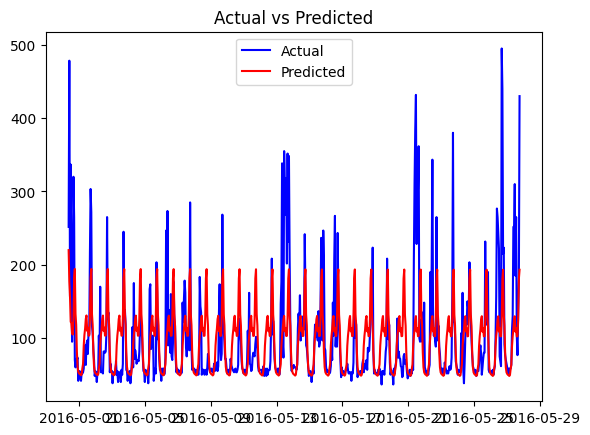

In [24]:
import matplotlib.pyplot as plt

# Plot actual values
plt.plot(test_data.index, actual_values, label='Actual', color='blue')

# Plot predicted values
plt.plot(test_data.index, test_predictions, label='Predicted', color='red')

plt.legend()
plt.title('Actual vs Predicted')
plt.show()